# **Training the VGG-16 model with augmentation for the classification of medical images**

I had to implement the deep neural network for my course work. So I decided to stop on the VGG-16 model, because it was my first experience in deep learning and this model looked simple enough.

The first step was to select a dataset. The choice fell on Retinal OCT Images.

Dataset consists from images of 4 classes: 

*   CNV - Neovascularization;
*   DME - Diabetic macular edema;
*   DRUSEN;
*   NORMAL.

Examples of classes:

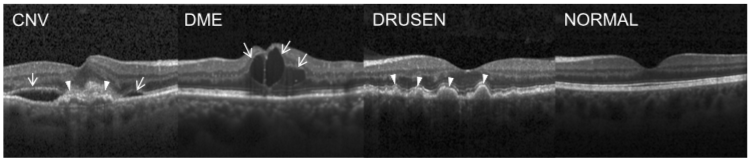

All images have different sizes.

Link to the dataset: https://www.kaggle.com/paultimothymooney/kermany2018



---

The model was written in Google Colaboratory by using frameworks and modules:

*   Shutil;
*   Pandas;
*   OpenCV;
*   Keras;
*   Scikit-learn;
*   NumPy;
*   CSV.

The pictures have been combined into one folder and zipped.


# Initializing Model Parameters

In [4]:
IMG_SIZE = 224 # Image default size for VGG-16 model
CHANNELS = 1 # It means we are working with black and white images
 
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
IMG_SIZES=(IMG_SIZE, IMG_SIZE)
NB_CLASSES = 4
EPOCHS = 10
BATCH_SIZE = 16

# Here you have to specify the name of the archive
zip_file = 'filename'

Mounting drive and unzipping acrhive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from zipfile import ZipFile

with ZipFile("/content/drive/My Drive/" + zip_file+ ".zip", 'r') as zip:
  zip.extractall()

# Data Preprocessing



**Resizing**

Here we're resizing our all images to default VGG-16 model size

In [7]:
from os import listdir
from os.path import isfile, join
import cv2
import os
import tensorflow as tf

os.chdir("/content/")
tf.io.gfile.mkdir('/content/EYE_DEFECTS/')

images = [f for f in listdir("/content/" + zip_file + "/") if isfile(join("/content/" + zip_file + "/", f))]

for img in images:
  im = cv2.imread("/content/" + zip_file + "/" + img, cv2.IMREAD_GRAYSCALE)
  im = cv2.resize(im, IMG_SIZES)
  cv2.imwrite("/content/EYE_DEFECTS/" + img, im)

**Splitting a dataset into samples**


Splitting was based on patient ID, because one patient can have multiple images.


In [8]:
import csv
import random
import pandas as pd
from os import listdir
from os.path import isfile, join

images = [f for f in listdir("/content/EYE_DEFECTS/") if isfile(join("/content/EYE_DEFECTS/", f))]

with open("/content/original.csv", 'w', newline='') as file:

  writer = csv.writer(file)
  writer.writerow(["Id"])
  for img in images:

    s = img.split("-")
    ss = s[2].split(".")
    if ss[0] == "1":
      writer.writerow([s[1]])


data = pd.read_csv("/content/original.csv")
images = list(data["Id"])
images = list(set(images))

random.shuffle(images)

train = [images[i] for i in range(4191)]
valid = [images[i] for i in range(4191, 4424)]
test  = [images[i] for i in range(4424, 4657)]

imgs = [f for f in listdir("/content/EYE_DEFECTS/") if isfile(join("/content/EYE_DEFECTS/", f))]

with open("/content/train.csv", 'w') as tf, open("/content/valid.csv", 'w') as vf, open("/content/test.csv", 'w') as tsf:
  tw = csv.writer(tf)
  vw = csv.writer(vf)
  tsw = csv.writer(tsf)

  vw.writerow(["Index", "Finding"])
  tsw.writerow(["Index", "Finding"])

  for img in imgs:

    id = img.split("-")[1]
    finding = img.split("-")[0]
    if int(id) in train:
      tw.writerow([img, finding])
    if int(id) in valid:
      vw.writerow([img, finding])
    if int(id) in test:
      tsw.writerow([img, finding])

**Augmentation**

I have used the simple augmentation way here. I just increased the number of shots of the least represented class: accidentally changed the intensity and brightness, added noise.

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
from random import randint

shutil.copy("/content/train.csv", "/content/train_copy.csv")

with open("/content/train.csv", 'r') as file, open("/content/train_aug.csv", 'w') as f:
  
  reader = csv.reader(file)
  writer = csv.writer(f)

  with open("/content/train_copy.csv", 'r') as copy:

    read = csv.reader(copy)

    counts = [0,0,0,0]
    for row in read:
      if row[1] == 'DME':
        counts[0]+=1
      if row[1] == 'CNV':
        counts[1]+=1
      if row[1] == 'DRUSEN':
        counts[2] += 1
      if row[1] == "NORMAL":
        counts[3] += 1
    maxval = max(counts)

  
  k = 10000

  diap = np.random.randint(200, 400)
  coin = np.random.randint(0,2)

  if coin == 0:
    coin = -1

  i = 0

  for row in reader:

    diag = row[1]
    writer.writerow([row[0], row[1]])

    img = cv2.imread("/content/EYE_DEFECTS/" + row[0], cv2.IMREAD_GRAYSCALE)


    if (diag =="DRUSEN" and counts[2] < maxval + coin * diap):

      aug_flag = randint(0,4)
      noise = np.random.normal(0,5,(224,224)).astype('uint8')
      img1 = img + noise
      cv2.imwrite("/content/EYE_DEFECTS/" + diag +"-aug1-" + str(k) + ".jpeg", img1)
      writer.writerow([diag + "-aug1-" + str(k) + ".jpeg", diag])

      alpha2 = randint(2,3)
      img2 = alpha2 * img

      cv2.imwrite("/content/EYE_DEFECTS/" + diag +"-aug2-" + str(k) + ".jpeg", img2)
      writer.writerow([diag + "-aug2-" + str(k) + ".jpeg", diag])

      beta3 = randint(-70, 71)
      img3 = img + beta3
  
      cv2.imwrite("/content/EYE_DEFECTS/" + diag +"-aug3-" + str(k) + ".jpeg", img3)
      writer.writerow([diag + "-aug3-" + str(k) + ".jpeg", diag])

      alpha4 = randint(2,3)
      beta4 = randint(-70,71)
      img4 = alpha4 * img + beta4
      noise = np.random.normal(0,5,(224,224)).astype('uint8')
      img4 += noise

      cv2.imwrite("/content/EYE_DEFECTS/" + diag +"-aug4-" + str(k) + ".jpeg", img4)
      writer.writerow([diag + "-aug4-" + str(k) + ".jpeg", diag])      

      i += 1
      k += 1

      counts[2] += 4

[10368, 33715, 7780, 23919] 



Splitting train sample on subsamples


Our train sample will be splitted into 31 parts, because augmentation is performed without using keras methods and it requires memory


In [7]:
with open("/content/train_aug.csv", 'r', newline='') as f:

      reader = csv.reader(f)
      data = [line for line in reader]
      random.shuffle(data)

with open("/content/train_aug.csv", 'w',newline='') as f:

      writer = csv.writer(f)
      writer.writerows(data)

SAMPLES = len(data) // 4000 + 1

with open('/content/train_aug.csv', "r", newline='') as csvfile:
  
  reader = csv.reader(csvfile, delimiter = ',')

  k = 1
    
  for row in reader:

    with open("/content/train_" + str(k // 4000) + ".csv", 'a', newline='') as f:
      writer = csv.writer(f)
      writer.writerow(row)

    k += 1

for i in range(SAMPLES):

  with open("/content/train_" + str(i) + ".csv", newline='') as f:

      reader = csv.reader(f)
      data = [line for line in reader]
      random.shuffle(data)

  with open("/content/train_" + str(i) + ".csv", 'w',newline='') as f:

      writer = csv.writer(f)
      writer.writerow(["Index", "Finding"])
      writer.writerows(data)

Copying files to the Drive for backup recovery

In [8]:
import datetime
import shutil
date = datetime.datetime.now().strftime("%d-%m-%Y")

for i in range(SAMPLES):
  shutil.copy("/content/train_" + str(i) + ".csv", "/content/drive/My Drive/labels/train_aug_" + str(i) + "_" + date + "_" + str(EPOCHS) + ".csv")

shutil.copy("/content/valid.csv", "/content/drive/My Drive/labels/valid_" + date + "_aug" + str(EPOCHS) + ".csv")
shutil.copy("/content/test.csv", "/content/drive/My Drive/labels/test_" + date + "_aug" + str(EPOCHS) + ".csv")

'/content/drive/My Drive/labels/test_12-11-2020_aug10.csv'

Conversion to numpy arrays


In [9]:
import numpy as np
import pandas as pd
import cv2
import csv
import tensorflow as tf
import os
import datetime
import shutil

tf.io.gfile.mkdir('/content/arrays/')

files = [
         "train", 
         "test", 
         "valid"
         ]

for file in files:

  if file == "train":
    for i in range(SAMPLES):
      data = pd.read_csv("/content/" + file +"_" + str(i) + ".csv")
      files_list = list(data['Index'])

      array = np.array([np.array(cv2.imread('/content/EYE_DEFECTS/' + img, cv2.IMREAD_GRAYSCALE)) for img in files_list])
      np.save("/content/arrays/" + file +"_" + str(i) + ".npy", array)

  else:
    data = pd.read_csv("/content/drive/My Drive/labels/" + file +"_"+ date + "_aug" + str(EPOCHS) + ".csv")
    files_list = list(data['Index'])

    array = np.array([np.array(cv2.imread('/content/EYE_DEFECTS/' + img, cv2.IMREAD_GRAYSCALE)) for img in files_list])
    np.save("/content/arrays/" + file + ".npy", array)

# Setting the model

In [10]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import MaxPooling2D


def create_model(optimizer, loss_function):

  model = Sequential();
  kernel_size=(3,3)
  drop_coef=0.1
  # Block 1
  model.add(Conv2D(64, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block1_conv1',
                      input_shape=INPUT_SHAPE
                      ))               
  model.add(Conv2D(64, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block1_conv2'
                      ))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_maxpool'))
  model.add(BatchNormalization())
  # Block 2
  model.add(Conv2D(128, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block2_conv1'
                      ))
  model.add(Conv2D(128, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block2_conv2'
                      ))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_maxpool'))
  model.add(BatchNormalization())
  # Block 3
  model.add(Conv2D(256, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block3_conv1'
                      ))
  model.add(Conv2D(256, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block3_conv2'
                      ))
  model.add(Conv2D(256, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block3_conv3'
                      ))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_maxpool'))
  model.add(BatchNormalization())
  
  # Block 4
  model.add(Conv2D(512, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block4_conv1'
                      ))
  model.add(Conv2D(512, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block4_conv2'
                      ))
  model.add(Conv2D(512, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block4_conv3'
                      ))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_maxpool'))
  model.add(BatchNormalization())
  
  # Block 5
  model.add(Conv2D(512, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block5_conv1'
                      ))
  model.add(Conv2D(512, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block5_conv2'
                      ))
  model.add(Conv2D(512, kernel_size,
                      activation='relu',
                      padding='same',
                      name='block5_conv3'
                      ))
  model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_maxpool'))
  model.add(BatchNormalization())
  
  
  # Block 6
  model.add(Flatten())
  model.add(Dense(4096))
      
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(drop_coef))
  
  model.add(Dense(4096))
      
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(Dropout(drop_coef))
  
  model.add(Dense(NB_CLASSES))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))
  

  model.compile(loss=loss_function,
                    optimizer=optimizer,
                    metrics=['accuracy'])
  
  model.summary()

  return model

# Training

**Losses and optimizers**

Gradient descent was used as an optimizer.
Mean squared error and categorical crossentropy were used as loss functions

In [11]:
from keras.optimizers import SGD

SGD = SGD(learning_rate=0.2, momentum=0.0, nesterov=False) 

LOSSES = [
            "mean_squared_error", 
            "categorical_crossentropy"
            ]
OPTIMIZERS = [ 
                [SGD, "SGD"], 
                # You can try other optimizers here
               ]

**Training**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import shutil
import json
import datetime
import csv

from keras.callbacks import TensorBoard
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras import backend
from keras.callbacks import ModelCheckpoint
from keras.models import load_model 
from sklearn.utils import class_weight

 
valid_labels = pd.read_csv("/content/drive/My Drive/labels/valid_" + date + "_aug" + str(EPOCHS) + ".csv")
X_valid = np.load("/content/arrays/valid.npy")
y_valid = valid_labels.Finding
label_encoder = LabelEncoder()
y_valid = label_encoder.fit_transform(y_valid)
y_valid = y_valid.reshape(-1, 1)
X_valid = X_valid.reshape(X_valid.shape[0], IMG_SIZE, IMG_SIZE, CHANNELS)
X_valid = X_valid.astype('float32')
X_valid = (X_valid - 128) / 255
y_valid = np_utils.to_categorical(y_valid, NB_CLASSES)
 
for LOSS in LOSSES:
  for OPTIMIZER in OPTIMIZERS:

    print("TRAINING MODEL ON", LOSS, "AND", OPTIMIZER[1])

    val_loss = 10**10
    val_accuracy = -1
    val_loss_history = []
    val_accu_history = []
    train_loss_history = []
    train_accu_history = []

    START_EPOCH = 0

    model = create_model(OPTIMIZER[0], LOSS)

    for k in range(START_EPOCH, EPOCHS):
    
      backend.clear_session()
      print("Epoch", str(k + 1)+ "/" + str(EPOCHS))

      if k != 0:
        
        model = load_model("/content/drive/My Drive/models/aug_buffer_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".h5")
        train_hist = pd.read_csv("/content/drive/My Drive/metrics/aug_buffer_train_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".csv")
        valid_hist = pd.read_csv("/content/drive/My Drive/metrics/aug_buffer_valid_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".csv")

        val_loss_history = list(valid_hist["loss"])
        val_accu_history = list(valid_hist["accuracy"])
        train_loss_history = list(train_hist["loss"])
        train_accu_history = list(train_hist["accuracy"])
    
        val_loss = min(val_loss_history)
        print(val_loss)

      for i in range(SAMPLES):
        
        backend.clear_session()
        print("SAMPLE", str(i + 1) + "/" + str(SAMPLES))
        train_labels = pd.read_csv("/content/drive/My Drive/labels/train_aug_" + str(i) + "_" + date + "_" + str(EPOCHS) + ".csv")
        X_train = np.load("/content/arrays/train_"+ str(i) + ".npy")
        y_train = train_labels.Finding


        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)

        y_train = y_train.reshape(-1, 1)
        X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, CHANNELS)
        X_train = X_train.astype('float32')
        X_train = (X_train - 128) / 255
        y_train = np_utils.to_categorical(y_train, NB_CLASSES)    

        history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    verbose=0
                    )

        del X_train
        del y_train
        
        train_loss_history.append(history.history["loss"][0])
        train_accu_history.append(history.history["accuracy"][0])
        print("train loss, train accuracy:", history.history["loss"][0], history.history["accuracy"][0])

      model.save("/content/drive/My Drive/models/aug_buffer_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".h5")
      model.save("/content/buffer_" + LOSS + "_" + OPTIMIZER[1]+".h5")
      
      val_results = model.evaluate(X_valid, y_valid, batch_size=BATCH_SIZE)
      val_loss_history.append(val_results[0])
      val_accu_history.append(val_results[1])
      print("val loss, val accuracy:", val_results)

      with open("/content/buffer_train_history_" + LOSS + "_" + OPTIMIZER[1] + ".csv", 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["loss", "accuracy"])
        for i in range(len(train_loss_history)):
          writer.writerow([train_loss_history[i], train_accu_history[i]])

      with open("/content/buffer_valid_history_" + LOSS + "_" + OPTIMIZER[1] + ".csv", 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["loss", "accuracy"])
        for i in range(len(val_loss_history)):
          writer.writerow([val_loss_history[i], val_accu_history[i]])

      if val_results[0] < val_loss:
        # Saving best weights
        model.save("/content/drive/My Drive/models/aug_best_model_" + LOSS + "_" + OPTIMIZER[1] + "_"  + date + "_" + str(EPOCHS) + ".h5")

      shutil.copy("/content/buffer_valid_history_" + LOSS + "_" + OPTIMIZER[1] + ".csv", "/content/drive/My Drive/metrics/aug_buffer_valid_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".csv")
      shutil.copy("/content/buffer_train_history_" + LOSS + "_" + OPTIMIZER[1] + ".csv", "/content/drive/My Drive/metrics/aug_buffer_train_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".csv")


    shutil.copy("/content/buffer_valid_history_" + LOSS + "_" + OPTIMIZER[1] + ".csv", "/content/drive/My Drive/metrics/aug_valid_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".csv")
    shutil.copy("/content/buffer_train_history_" + LOSS + "_" + OPTIMIZER[1] + ".csv", "/content/drive/My Drive/metrics/aug_train_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date + ".csv")


# Testing


Testing and confusion matrix construction

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.math import confusion_matrix
from keras.utils import np_utils
from keras.models import load_model 
import matplotlib.pyplot as plt
import itertools
import numpy as np
import seaborn as sns


def plot_cm(con_mat_norm, temp):
  
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)


    con_mat_df = pd.DataFrame(con_mat_norm,
                              index = temp, 
                              columns = temp 
                              )

    figure = plt.figure(figsize=(con_mat_norm.shape[0], con_mat_norm.shape[1]))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/content/drive/My Drive/plots/conf_matrix_" + LOSS + "_" + OPTIMIZER[1] + "_"  + date + "_" + str(EPOCHS) + ".png")
    plt.show()


path = "/content/drive/My Drive/labels/test_" + date + "_aug" + str(EPOCHS) + ".csv"
test_labels = pd.read_csv(path)

X_test = np.load("/content/arrays/test.npy")
y_test = test_labels.Finding
temp = y_test.copy()
le = LabelEncoder()
temp = le.fit(temp)
temp = list(le.classes_)


label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_test = y_test.reshape(-1, 1)
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE, IMG_SIZE, CHANNELS)
X_test = X_test.astype('float32')
X_test = (X_test - 128) / 255
y_test = np_utils.to_categorical(y_test, NB_CLASSES)

buf_test = y_test.copy()

with open("/content/drive/My Drive/logs.csv", 'a', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(["Model params", "accuracy", "precision", "recall", "f1"])

  for LOSS in LOSSES:
    for OPTIMIZER in OPTIMIZERS:

      model = load_model("/content/drive/My Drive/models/aug_best_model_" + LOSS + "_" + OPTIMIZER[1] + "_"  + date1 + "_" + str(EPOCHS) + ".h5")

      y_pred = model.predict(X_test)
      y_test = np.argmax(buf_test, axis=1)
      y_pred = np.argmax(y_pred, axis=1)

      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, average='macro')
      recall = recall_score(y_test, y_pred, average='macro')
      f1 = f1_score(y_test, y_pred, average="macro")
      print("FOR", LOSS, OPTIMIZER[1], "MODEL")
      print(accuracy)
      print("Precision: ", precision)
      print("Recall: ", recall)
      print("F1: ", f1)
      
      writer.writerow([LOSS+" "+OPTIMIZER[1]+" "+str(EPOCHS)+" EPOCHS " + date, accuracy, precision, recall, f1])

      con_mat = confusion_matrix(labels=y_test, predictions=y_pred).numpy()
      plot_cm(con_mat, temp)

Displaying graphs

In [ ]:
for LOSS in LOSSES:
  for OPTIMIZER in OPTIMIZERS:
 
    train_hist = pd.read_csv("/content/drive/My Drive/metrics/aug_train_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date1 + ".csv")
    valid_hist = pd.read_csv("/content/drive/My Drive/metrics/aug_valid_metrics_" + LOSS + "_" + OPTIMIZER[1] + "_" + date1 + ".csv")

    val_loss_history = list(valid_hist["loss"])
    val_accu_history = list(valid_hist["accuracy"])
    train_loss_history = list(train_hist["loss"])
    train_accu_history = list(train_hist["accuracy"])

    #  "Accuracy"
    plt.plot(train_accu_history)
    plt.title('model train accuracy')
    plt.ylabel('accuracy')
    plt.savefig("/content/drive/My Drive/plots/accu_train_" + LOSS + "_" + OPTIMIZER[1] + "_"  + date1 + "_" + str(EPOCHS) + ".png")
    plt.show()
    # "Loss"
    plt.plot(train_loss_history)
    plt.title('model train loss')
    plt.ylabel('loss')
    plt.savefig("/content/drive/My Drive/plots/loss_train_" + LOSS + "_" + OPTIMIZER[1] + "_"  + date1 + "_" + str(EPOCHS) + ".png")
    plt.show()

    #  "Accuracy"
    plt.plot(val_accu_history)
    plt.title('model val accuracy')
    plt.ylabel('accuracy')
    plt.savefig("/content/drive/My Drive/plots/accu_valid_" + LOSS + "_" + OPTIMIZER[1] + "_"  + date1 + "_" + str(EPOCHS) + ".png")
    plt.show()
    # "Loss"
    plt.plot(val_loss_history)
    plt.title('model val loss')
    plt.ylabel('loss')
    plt.savefig("/content/drive/My Drive/plots/loss_valid_" + LOSS + "_" + OPTIMIZER[1] + "_"  + date1 + "_" + str(EPOCHS) + ".png")
    plt.show()

# Results

Now you can see confusion matrixes for model with augmentation.

First matrix is for a model with mean squared error as a loss fucntion.
Second matrix is for a model with crossentropy as a loss function.

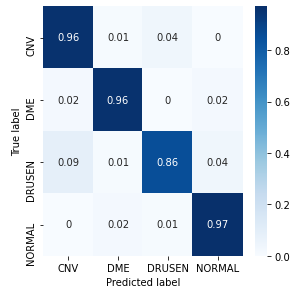

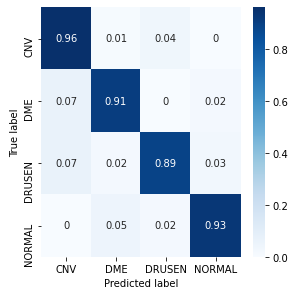